# Dynamic optimization

**Table of contents**<a id='toc0_'></a>    
- 1. [Interpolation](#toc1_)    
  - 1.1. [Example](#toc1_1_)    
- 2. [Problem formulation](#toc2_)    
- 3. [Solve household problem](#toc3_)    
  - 3.1. [Increasing the number of periods](#toc3_1_)    
- 4. [Simulation](#toc4_)    
- 5. [Summary](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

You will learn simple function approximation using linear interpolation (**scipy.interp**). You will learn to numerically solve general dynamic optimization problems

This subject is _hard_. But also extremely useful. If you master this, you can solve (almost) all economic models you meet on your way in life.

**Links:**

1. **scipy.optimize:** [overview](https://docs.scipy.org/doc/scipy/reference/optimize.html) + [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)
2. **scipy.interp:** [overview](https://docs.scipy.org/doc/scipy/reference/interpolate.html) + [tutorial](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)

In [1]:
from types import SimpleNamespace
import time
import numpy as np
from scipy import optimize
from scipy import interpolate

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Interpolation](#toc0_)

**Intermezzo:** To consider dynamic optimization problems, we need to think about interpolation.

**Inputs:**

1. Sorted vector of known points (grid vector), $G = \{G_i\}_{i=0}^{n-1}$
2. Vector of known values (at these points), $F = \{F_i = f(G_i)\}_{i=0}^{n-1}$
3. A new point, `x`

**Algorithm:** `linear_interpolate()`
1. Determine `i`  such that

$$
G_i \leq x < G_{i+1}
$$

2. Compute interpolated value by

$$
y =  F_{i} + \frac{F_{i+1}-F_{i}}{G_{i+1}-G_{i}}(x-G_{i})
$$

**Extrapolation:**

1. Below where $x < G_1$: 

$$
y =  F_{0} + \frac{F_{1}-F_{0}}{G_{1}-G_{0}}(x-G_{0})
$$

2. Above where $x > G_{n-2}$: 

$$
y =  F_{n-2} + \frac{F_{n-1}-F_{n-2}}{G_{n-1}-G_{n-2}}(x-G_{n-2})
$$

In [2]:
def linear_interpolate(G,F,x):
    """ linear interpolation (and extrapolation)
    
    Args:
    
        G (np.ndarray): known points
        F (np.ndarray): known values
        x (float): point to be interpolated
        
    Returns:
    
        y (float): intepolated value
    
    """
    
    assert len(G) == len(F)
    n = len(G)
    
    # a. find index in known points
    if x < G[1]: # exprapolation below
        i = 0
    elif x > G[-2]: # extrapolation above
        i = n-2
    else: # true interpolation
        
        # search
        i = 0 
        while x >= G[i+1] and i < n-1:
            i += 1
        
        assert x >= G[i]
        assert x < G[i+1]

    # b. interpolate
    diff_G = G[i+1]-G[i]
    diff_F = F[i+1]-F[i]
    slope = diff_F/diff_G
    y = F[i] + slope*(x-G[i])
    
    return y

### 1.1. <a id='toc1_1_'></a>[Example](#toc0_)

Consider the following function and known points:

In [3]:
f = lambda x: (x-3)**3 - 3*x**2 + 5*x

G = np.linspace(-5,10,6)
F = f(G)

**Simple test:**

In [4]:
for x in [-2.3,4.1,7.5,9.1]:
    true = f(x)
    y = linear_interpolate(G,F,x)
    print(f'x = {x:4.1f} -> true = {true:6.1f}, interpolated = {y:6.1f}')

x = -2.3 -> true = -176.2, interpolated = -193.5
x =  4.1 -> true =  -28.6, interpolated =  -27.7
x =  7.5 -> true =  -40.1, interpolated =  -24.5
x =  9.1 -> true =   24.1, interpolated =   50.7


**Scipy.interpolate:** Use the *RegularGridInterpolator*  

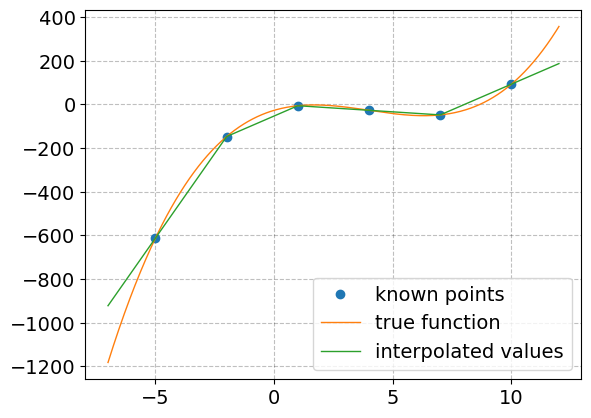

In [5]:
# a. construct interpolation function
interp_func = interpolate.RegularGridInterpolator([G],F,
                                                  bounds_error=False,
                                                  fill_value=None)

# bounds_error=False and fill_value=None allow for extrapolation

# b. interpolate
grid = np.linspace(-7,12,500)
interp_values = interp_func(grid)

# c. evaluate true values
true_values = f(grid)

# d. plot true and interpolated values
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(G,F,'o',label='known points')
ax.plot(grid,true_values,'-',lw=1,label='true function')
ax.plot(grid,interp_values,'-',lw=1,label='interpolated values')
ax.legend(loc='lower right',facecolor='white',frameon=True);

**Task:** Increase the number of known points and see what happens.

**Note:**

1. Linear interpolation works best when the function does not curve too much.
2. Extrapolation is much worse than interpolation.

**Multiple dimensions:** Same principle, ``interpolate.RegularGridInterpolator([G1,G2,G3],F)``.

## 2. <a id='toc2_'></a>[Problem formulation](#toc0_)

Consider a **household** living in two periods.

In the **second period** it gets utility from **consuming** and **leaving a bequest** (warm glow),

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand 
* $c_2$ is consumption
* $a_2$ is end-of-period assets 
* $\rho > 1$ is the risk aversion coefficient
* $\nu > 0 $ is the strength of the bequest motive
* $\kappa > 0$ is the degree of luxuriousness in the bequest motive  
* $a_2\geq0$ ensures the household *cannot* die in debt

The **value function** $v(m_2)$ measures the household's value of having $m_2$ at the beginning of period 2.

In [6]:
def utility(c,par):
    return c**(1-par.rho)/(1-par.rho)

def bequest(m,c,par):
    return par.nu*(m-c+par.kappa)**(1-par.rho)/(1-par.rho)

def v_last_period(c,m,par):
    return utility(c,par) + bequest(m,c,par)

In the **first period**, the household gets utility from consuming and takes into account that it will also live in the next-period, where it receives a stochastic income,

$$
\begin{aligned}
v_1(m_1)&=\max_{c_1}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
a_1&=m_1-c_1\\
m_2&= (1+r)a_1+y_2 \\
y_{2}&= \begin{cases}
1+\Delta & \text{with prob. }p\\
1-\Delta & \text{with prob. }1-p 
\end{cases}\\
a_1&\geq0
\end{aligned}
$$

where

* $m_1$ is cash-on-hand in period 1
* $c_1$ is consumption in period 1
* $a_1$ is end-of-period assets in period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y_2$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving if $p = 0.5$)
* $r$ is the interest rate
* $a_1\geq0$ ensures the household *cannot* borrow

In [7]:
def v(c,m,par,v_plus_interp):
    
    # a. expected value
    v_plus = 0.0
    for p,y in [(par.p,1+par.Delta),((1.0-par.p,1-par.Delta))]:
        
        # i. next period cash-on-hand
        a = m-c
        m_plus = (1+par.r)*a + y
        
        # ii. next-period values
        v_plus_now = v_plus_interp([m_plus])[0]
        
        # iii. probability weighted sum
        v_plus += p*v_plus_now
    
    # b. total value
    return utility(c,par) + par.beta*v_plus

**Our goal:** Find the value functions, $v_2(m_2)$ and $v_1(m_1)$, and associated consumption functions, $c^{\ast}_2(m_2)$ and $c^{\ast}_1(m_1)$ on some grid for $m$.

## 3. <a id='toc3_'></a>[Solve household problem](#toc0_)

Choose **parameters**:

In [8]:
par = SimpleNamespace()

# preferences
par.rho = 8.0
par.nu = 0.1
par.kappa = 0.5
par.beta = 0.94

# return and income
par.r = 0.04
par.p = 0.5
par.Delta = 0.5

# grid
par.Nm = 500 # number of grid points for m
par.m_min = 1e-4 # minimum value for m
par.m_max = 5.0 # maximum value for m

**Solve second period:**

In [9]:
def solve_last_period(par):

    # a. allocate
    m_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    c_func = np.empty(par.Nm)

    # b. solve
    for i,m in enumerate(m_grid):

        # i. objective
        obj = lambda x: -v_last_period(x[0],m,par)

        # ii. optimizer
        x0 = m/2 # initial value
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,m),))

        # iii. save
        v_func[i] = -result.fun
        c_func[i] = result.x
        
    return m_grid,v_func,c_func

**Solve:**

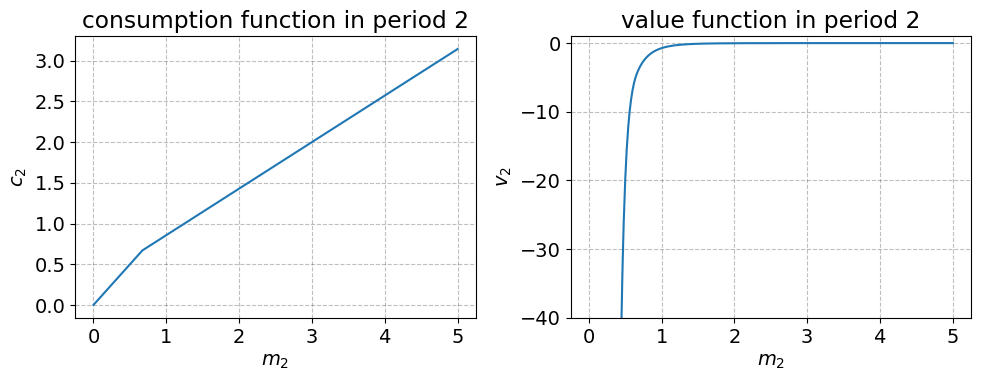

In [10]:
m2_grid,v2_func,c2_func = solve_last_period(par)

# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m2_grid,c2_func)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$c_2$')
ax.set_title('consumption function in period 2')

ax = fig.add_subplot(1,2,2)
ax.plot(m2_grid,v2_func)
ax.set_xlabel('$m_2$')
ax.set_ylabel('$v_2$')
ax.set_title('value function in period 2')
ax.set_ylim([-40,1])

fig.tight_layout(pad=1.0)

**Note:** We now solve for the consumption function, rather than a specific optimum.

**Question:** Why is there a kink in the consumption function?

**Construct interpolator:**

In [11]:
v2_func_interp = interpolate.RegularGridInterpolator([m2_grid],v2_func,bounds_error=False,fill_value=None)

**Solve first period:**

In [12]:
def solve_single_period(par,v_plus_interp):

    # a. allocate
    m_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    c_func = np.empty(par.Nm)
    
    # b. solve
    for i,m in enumerate(m_grid):
        
        # i. objective
        obj = lambda x: -v(x[0],m,par,v_plus_interp)
        
        # ii. solve
        x0 = m/2 # initial guess
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,m),))
        
        # iv. save
        v_func[i] = -result.fun
        c_func[i] = result.x[0]
     
    return m_grid,v_func,c_func

**Solve:**

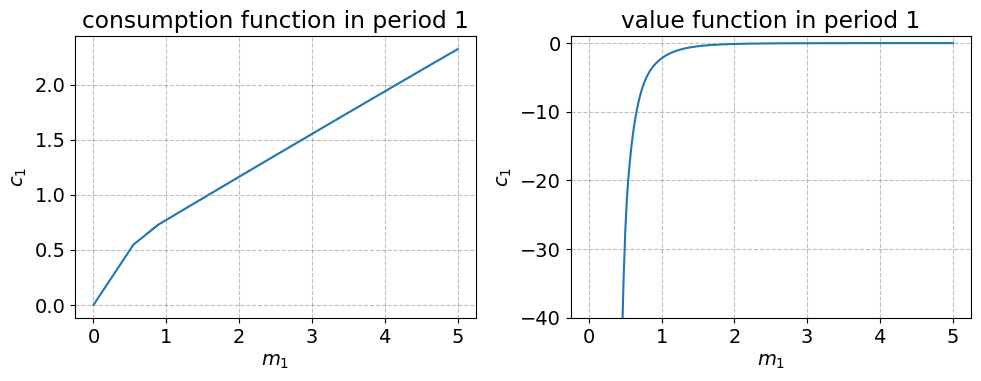

In [13]:
m1_grid,v1_func,c1_func = solve_single_period(par,v2_func_interp)

# illustrate
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m1_grid,c1_func)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')

ax = fig.add_subplot(1,2,2)
ax.plot(m1_grid,v1_func)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')
ax.set_ylim([-40,1])

fig.tight_layout(pad=1.0)

**Summary:** We can summarize what we have done in a single function doing:

1. Solve period 2 (i.e. find $v_2(m_2)$ og $c_2(m_2)$)
2. Construct interpolator of $v_2(m_2)$
3. Solve period 1 (i.e. find $v_1(m_1)$ og $c_1(m_1)$)

In [14]:
def solve(par):
    
    # a. solve period 2
    m2_grid,v2_func,c2_func = solve_last_period(par)
    
    # b. construct interpolator
    v2_func_interp = interpolate.RegularGridInterpolator([m2_grid], v2_func,
        bounds_error=False,fill_value=None)
    
    # b. solve period 1
    m1_grid,v1_func,c1_func = solve_single_period(par,v2_func_interp)
    
    return m1_grid,c1_func,m2_grid,c2_func

**Plot consumption function for various level of income risk**, i.e varios $\Delta$

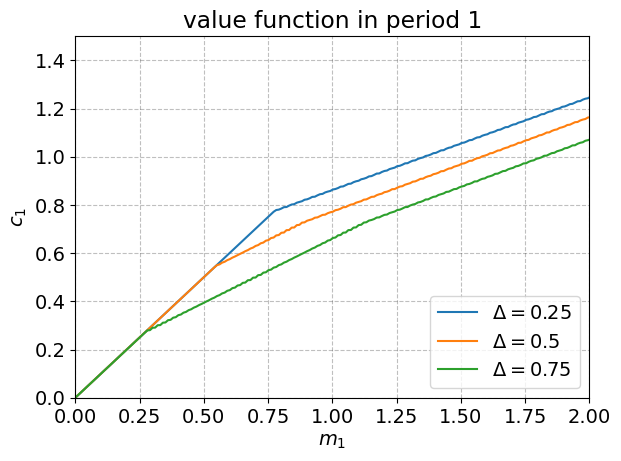

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

_Delta = par.Delta
for Delta in [0.25,0.50,0.75]:
    par.Delta = Delta
    m1_grid,c1_func,m2_grid,c2_func = solve(par)
    ax.plot(m1_grid,c1_func,label=f'$\Delta = {Delta}$')
    par.Delta = _Delta # reset
    
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5])

fig.tight_layout(pad=1.0)

**Main takeaway:** The household lowers its consumption when risk increases (such as in a recession). This is called **precautionary saving**.

**Task:** Discuss how to extend the consumer problem in some way or another.

### 3.1. <a id='toc3_1_'></a>[Increasing the number of periods](#toc0_)

In [16]:
def solve_many_periods(par):
    
    t0 = time.time()
    
    # a. allocate
    m = np.zeros((par.T,par.Nm))
    v = np.zeros((par.T,par.Nm))
    c = np.zeros((par.T,par.Nm))
    
    # b. iterate
    for t in reversed(range(par.T)):
        
        t0_ = time.time()
        
        if t == par.T-1:
            
            m[t,:],v[t,:],c[t,:] = solve_last_period(par)
            
        else:
    
            # i. construct interpolator
            v_plus_interp = interpolate.RegularGridInterpolator([m[t+1,:]],v[t+1,:],
                bounds_error=False,fill_value=None)
    
            # ii. solve period
            m[t,:],v[t,:],c[t,:] = solve_single_period(par,v_plus_interp)
        
        print(f'period {t} solved in {time.time()-t0_:5.1f} secs')
        
    print(f'model solved in {time.time()-t0:5.1f} secs')
    
    return m,c
                

**Solve:**

In [17]:
par.T = 10
m_grids,c_funcs = solve_many_periods(par)

period 9 solved in   0.5 secs
period 8 solved in   4.3 secs
period 7 solved in   3.8 secs
period 6 solved in   4.2 secs
period 5 solved in   3.8 secs
period 4 solved in   3.7 secs
period 3 solved in   3.6 secs
period 2 solved in   3.4 secs
period 1 solved in   3.5 secs
period 0 solved in   3.4 secs
model solved in  34.1 secs


**Plot:**

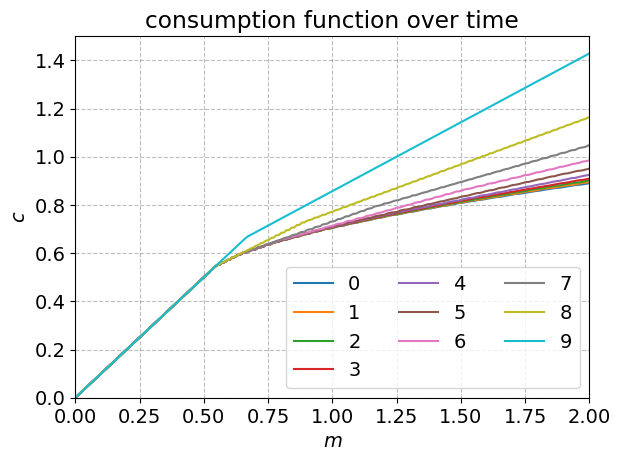

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for t in range(par.T):
    ax.plot(m_grids[t,:],c_funcs[t,:],label=f'{t}')

ax.legend(loc='lower right',facecolor='white',ncol=3,frameon=True)
ax.set_xlabel('$m$')
ax.set_ylabel('$c$')
ax.set_title('consumption function over time')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5])

fig.tight_layout(pad=1.0)

## 4. <a id='toc4_'></a>[Simulation](#toc0_)

**Step 1:** Construct interpolators from solution:

In [19]:
c_interps = []
for t in range(par.T):
    c_interp = interpolate.RegularGridInterpolator([m_grids[t,:]],c_funcs[t,:],bounds_error=False,fill_value=None)
    c_interps.append(c_interp)


**Step 2:** Draw initail distribution of lagged assets $a_0$ and simulate forward

In [20]:
# a. allocate
simN = 10_000

sim_m = np.zeros((par.T,simN))
sim_y = np.zeros((par.T,simN))
sim_c = np.zeros((par.T,simN))
sim_a = np.zeros((par.T,simN))

# b. simulate
a0 = np.random.exponential(size=simN) # arbitrary choice of distribution
for t in range(par.T):
    
    # i. lagged assets
    if t == 0:
        a_lag = a0
    else:
        a_lag = sim_a[t-1,:]
    
    # ii. income
    p_vec = [par.p,1-par.p]
    y_vec = [1+par.Delta,1-par.Delta]
    sim_y[t,:] = np.random.choice(y_vec,p=p_vec,size=simN)
    
    # iii. cash-on-hand
    sim_m[t] = (1+par.r)*a_lag + sim_y[t,:]
    
    # iv. consumption-saving
    sim_c[t,:] = c_interps[t](sim_m[t,:])
    sim_a[t,:] = sim_m[t,:]-sim_c[t,:]

**Step 3:** Plot distributions

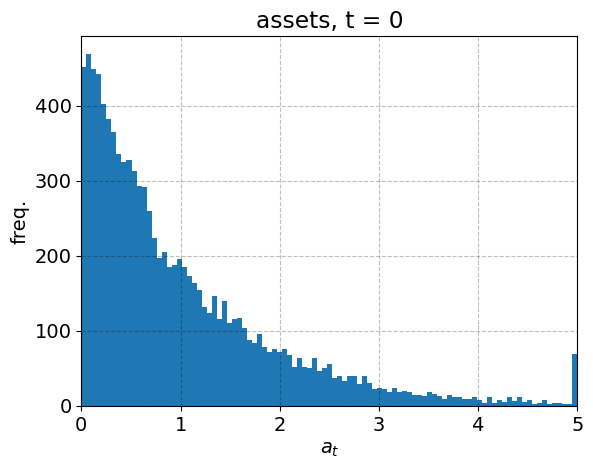

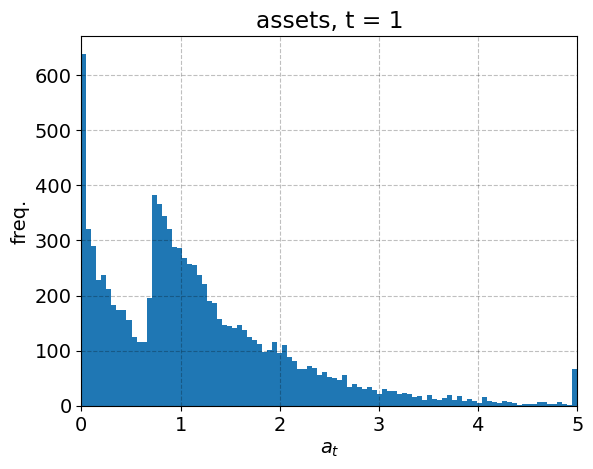

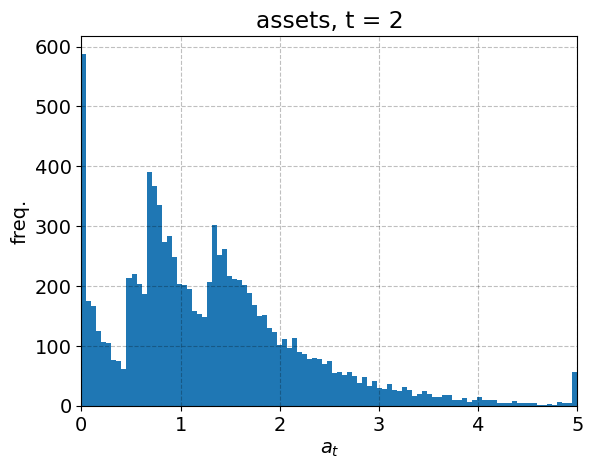

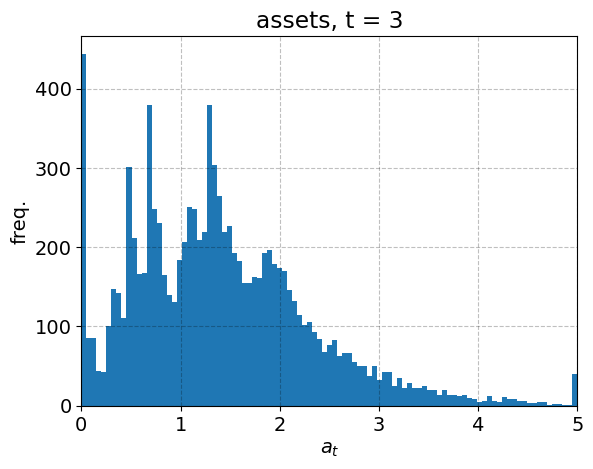

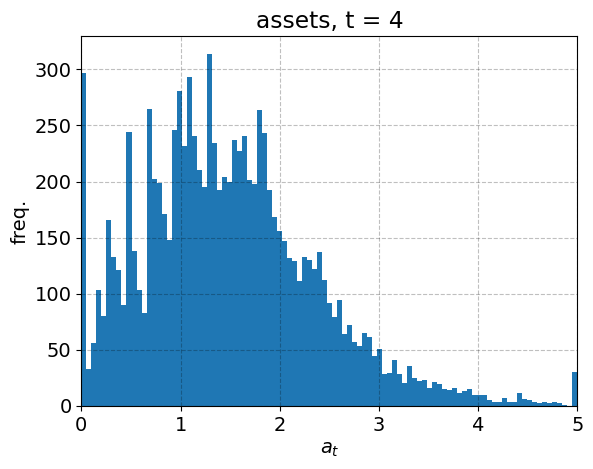

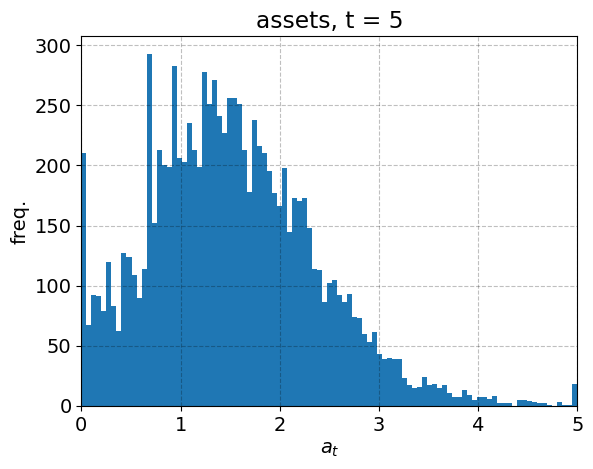

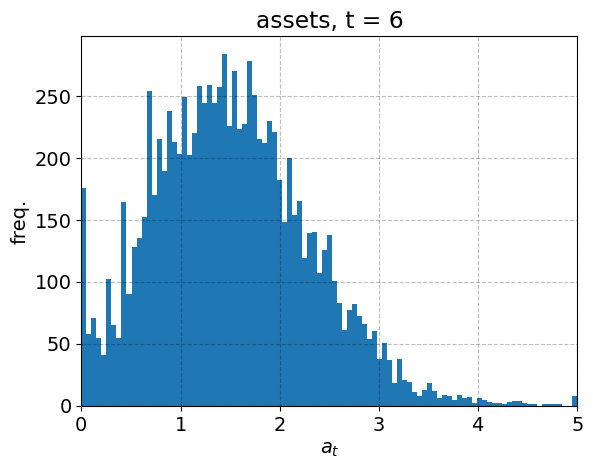

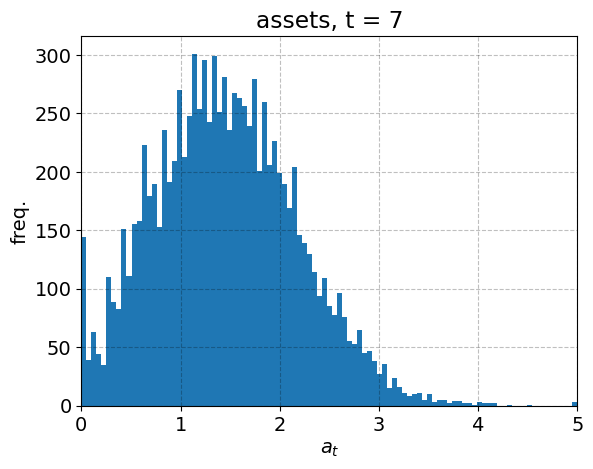

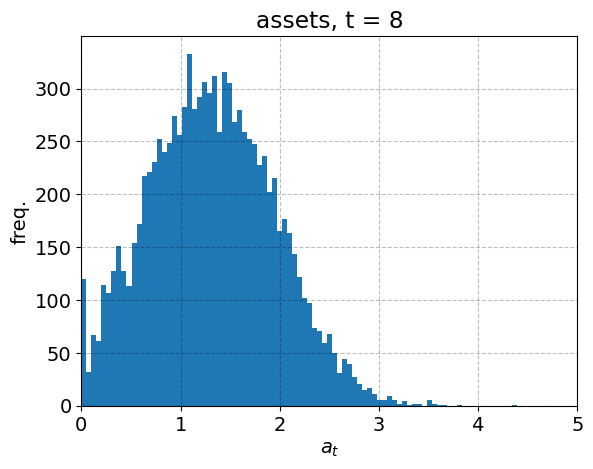

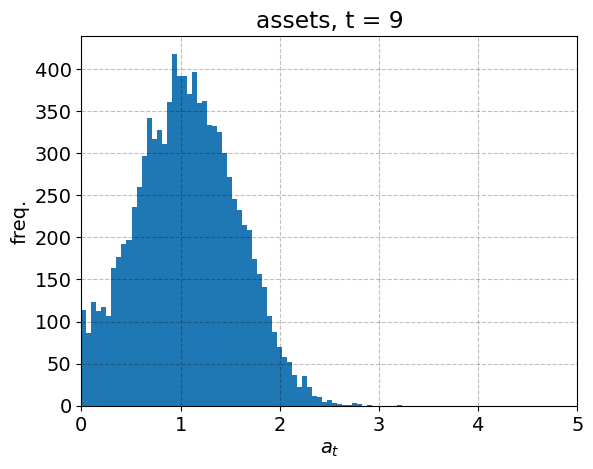

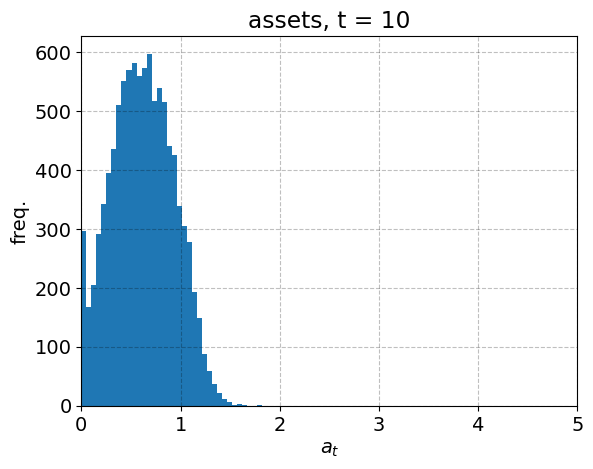

In [21]:
for t in range(-1,par.T):
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    bins = np.linspace(0,5,100)
    if t == -1:
        ax.hist(np.fmin(a0,5),bins=bins)
    else:
        ax.hist(np.fmin(sim_a[t,:],5),bins=bins)
        
    ax.set_title(f'assets, t = {t+1}')
    ax.set_xlabel('$a_t$')
    ax.set_ylabel('freq.')
    ax.set_xlim([0,5])

**Conclusion:** You can now solve models with complex heterogeneity and uncertainty, and simulate the implied dynamics. By introducing various policies you can quantify their effect not just for the average, but for the full distribution.

## 5. <a id='toc5_'></a>[Summary](#toc0_)

**Dynamic optimization:** Extremely useful technique. Can handle multiple periods, multiple states and choices, more shocks etc. You can solve general equilibrium models where the households solve such problems.

**Master courses:**

1. *Dynamic Programming - Theory, Computation, and Empirical Applications* by [Bertel Schjerning](https://bschjerning.com/)
1. *Advanced Macroeconomics: Heterogenous Agent Models* by [Jeppe Druedahl](https://sites.google.com/view/jeppe-druedahl/)
1. *Household Behavior over the Life Cycle* by [Thomas Høgholm Jørgensen](https://www.tjeconomics.com/)